FUNCTIONS FOR SCRIPT

In [1]:
%matplotlib inline

def estimate__e_s(T): 
    from xray import ufuncs
    T0 = 273.15 ## Kelvin, reference temperature
    e_s = 611 * ufuncs.exp((17.67 * (T - T0)) / (T - 29.65) )
    return(e_s)

def estimate_p(h):
    p = 101325 * (1 - ((2.25577 * 10**-5) * h))**5.25588 ## Pascals 
    return(p)

def estimate_relative_humidity(q,e_s,p):
    ## estimates relative humidity using hypsometric equation for pressure, virtual temperature and 
    ## average temperature 
    import numpy as np
    w = q ## approximating the mixing ratio as the specific humidity
    w_s = 0.622 * (e_s / p)
    RH = 100.0 * (w / w_s)
    return (RH)

def estimate_emc(RH,T):
    if RH < 10: 
        EMC = 0.03229 + (0.281073 * RH) - (0.000578 * T * RH)
    elif RH >= 10 and RH <= 50:
        EMC = 2.22749 + (0.160107*RH) - (0.014784*T)
    else: 
        EMC = 21.0606 + (0.005565*(RH**2)) - (0.00035*RH*T) - (0.483199*RH)
    return(EMC)

def nfdrs_climate_class(lon):
    ## use eastern boundary of the Cascades to delineate (this might need refinement)
    if lon > -122.5:
        climate_class = 2
        wetrat = 0.25
    else:
        climate_class = 3
        wetrat = 0.05
    return(climate_class,wetrat)

def Kelvin_to_Fahrenheit(T_dataset,T_time):
    ## convert temps to Fahrenheit (this is required for EMC calculations developed by Simard 1968)
    # ºF =(K - 273.15)* 1.8000 + 32.00
    if (T_time == "tmin"):
        T_dataset['air_temp_min'].values = ((T_dataset.air_temp_min.values - 273.15) * 1.8) + 32.0
    elif (T_time == "tmax"):
        T_dataset['air_temp_max'].values = ((T_dataset.air_temp_max.values - 273.15) * 1.8) + 32.0
    else:
        T_dataset.values = ((T_dataset.values - 273.15) * 1.8) + 32.0
    return(T_dataset)

LOAD IS SIMULATIONS DATA

In [2]:
## note this forcing data is for the entire CONUS so i need to mask out what isn't in the CRB 
## note: for masking, ufunc functions can be used directly on a DataArray
%load_ext autoreload
################################# INPUTS #############################
lat = 48.03125
lon = -121.28125
######################################################################
import numpy as np
import xray
from xray import ufuncs
import os
import math 
import gc 
import pandas as pd 

basin = "cascades"
model = "CCSM4"
scenario = "historical"

direc = '/raid/gergel/%s' % "tmin"
tmin_file = "%s_%s_%s.nc" % (model,scenario,"tasmin")
tmin_full = xray.open_dataset(os.path.join(direc,tmin_file)) ## load tmin

direc = '/raid/gergel/%s' % "tmax"
tmax_file = "%s_%s_%s.nc" % (model,scenario,"tasmax")
tmax_full = xray.open_dataset(os.path.join(direc,tmax_file)) ## load tmax

direc = '/raid/gergel/%s' % "rh"
sh_file = "%s_%s_%s.nc" % (model,scenario,"huss")
q_full = xray.open_dataset(os.path.join(direc,sh_file)) ## load specific humidity 

direc = '/raid/gergel/%s' % "precip"
pr_file = "%s_%s_%s.nc" % (model,scenario,"pr")
pr_full = xray.open_dataset(os.path.join(direc,pr_file)) ## load precip

## adjust lat/lon dimensions since the index names are different
tmin_lons_new = tmin_full['lon'].values[tmin_full['lon'].values > 180] - 360 
tmin_full['lon'] = tmin_lons_new
tmax_full['lon'] = tmin_lons_new
q_full['lon'] = tmin_lons_new 
pr_full['lon'] = tmin_lons_new

## select out gridcell 
lon_ind = np.where(np.asarray(tmin_full.lon).astype('|S10') == np.str(lon))[0][0]
lat_ind = np.where(np.asarray(tmin_full.lat).astype('|S8') == np.str(lat))[0][0]

## get julian days 
julians = pd.DatetimeIndex(np.asarray(pr_full.time)).dayofyear

# tmin = tmin_full[:,lat_ind,lon_ind]
tmin = tmin_full.isel_points(lon=[lon_ind],lat=[lat_ind])
tmax = tmax_full.isel_points(lon=[lon_ind],lat=[lat_ind])
q = q_full.isel_points(lon=[lon_ind],lat=[lat_ind])
pptamt = pr_full.isel_points(lon=[lon_ind],lat=[lat_ind])


del tmin_full,tmax_full, q_full,pr_full
gc.collect() 

770

GET DFM FROM IS SIMULATIONS DATA

In [3]:
t_avg = (tmin.air_temp_min + tmax.air_temp_max)/2.0

## get elevation of grid cell
from snowpack_functions import get_elev_for_lat_lon,import_gridcell_elevation 
soil_file = '/raid9/gergel/agg_snowpack/soil_avail.txt'
elev_corr_info = import_gridcell_elevation(soil_file) 
h = get_elev_for_lat_lon(elev_corr_info,lat,lon)

## get pressure 
p = estimate_p(h)

## get sat vap pressure
e_s = estimate__e_s(t_avg)
#e_s = estimate__e_s(tmin.air_temp_min) ## try using minimum air temperature rather than average 

## estimate relative humidity
RH = estimate_relative_humidity(q,e_s,p)

## if RH > 100, RH = 100
RH_new_vals = np.ndarray(shape=(1,len(RH.specific_humidity.values[0,:])),dtype='float')
for val in np.arange(len(RH.specific_humidity.values[0,:])):
    if RH.specific_humidity.values[0,val] > 100:
        RH_new_vals[0,val] = 100
    else:
        RH_new_vals[0,val] = RH.specific_humidity.values[0,val]
RH.specific_humidity.values = RH_new_vals

## estimate vapor pressures
satvpd = e_s ## this was already calculated
satvpx = estimate__e_s(tmax.air_temp_max)
satvpn = estimate__e_s(tmin.air_temp_min)

ambvp = (RH * satvpd) / 100.0
RHmax = 100.0 * (ambvp/satvpn)
RHmin = 100.0 * (ambvp/satvpx)

## if RHmax > 100, RHmax = 100
RHmax_new_vals = np.ndarray(shape=(1,len(RHmax.specific_humidity.values[0,:])),dtype='float')
for val in np.arange(len(RHmax.specific_humidity.values[0,:])):
    if RHmax.specific_humidity.values[0,val] > 100:
        RHmax_new_vals[0,val] = 100
    else:
        RHmax_new_vals[0,val] = RHmax.specific_humidity.values[0,val]
RHmax.specific_humidity.values = RHmax_new_vals

## get climate class and rainfall rate 
climat,wetrat = nfdrs_climate_class(lon)
pptamt_in = pptamt * 0.0393701 ## convert from mm to inches 
pptdur = ufuncs.rint((pptamt_in/wetrat) + 0.49)

## convert temps to Fahrenheit
tmax_F = Kelvin_to_Fahrenheit(tmax,"tmax")
tmin_F = Kelvin_to_Fahrenheit(tmin,"tmin")
t_avg_F = Kelvin_to_Fahrenheit(t_avg,"t_avg")

## estimate EMCs
EMCmin = estimate_emc(RHmin,tmax_F.air_temp_max)
#EMC = estimate_emc(RH,t_avg)
EMC = estimate_emc(RH,tmin_F.air_temp_min)
#EMC = EMCmin
# EMCmin = EMC
EMCmax = estimate_emc(RHmax,tmin_F.air_temp_min)
# EMCMAX = 0.15

phi = lat * 0.01745 ## lat is in degrees 
decl = 0.41008*np.sin((julians-82) * 0.01745)
daylit = 24 * (1.0 - ((np.arccos(np.tan(np.deg2rad(phi)) * np.tan(decl))) / math.pi))

EMCbar = ((daylit * EMCmin) + (24 - daylit) * EMCmax) / 24.0 

bndryh = ( ( (24.0 - pptdur.precipitation) * EMCbar.specific_humidity) + pptdur.precipitation * 
          ( (0.5 * pptdur.precipitation) + 41.0 ) )/ 24.0 

################################################ calculate 100-hr timelag ######################################## 

## to initialize YMC100 at the beginning of a period
YMC100_0 = 5.0 + (5.0 * climat)

arr_mc100 = np.ndarray(shape=(len(julians)),dtype='float')

for day in np.arange(len(julians)):
    if day == 0:
        YMC100 = YMC100_0
    else: 
        YMC100 = arr_mc100[day-1]
    arr_mc100[day] = YMC100 + (np.float(bndryh.values[0,day]) - YMC100) * (1.0 - (0.87 * np.exp(-0.24) ) )

LOAD UI METDATA FOR DFM COMPARISON WITH IS DATA

In [4]:
################################# INPUTS #############################
lat = 48.03125
lon = -121.28125
######################################################################

direc = '/raid/gergel/dfm_ui_metdata'
tmin_file1 = "tmmn_%s.nc" % "1981"
tmin_file2 = "tmmn_%s.nc" % "1982"
tmin_full1 = xray.open_dataset(os.path.join(direc,tmin_file1)) ## load tmin
tmin_full2 = xray.open_dataset(os.path.join(direc,tmin_file2)) ## load tmin
tmin_full = xray.concat([tmin_full1, tmin_full2], dim='day')

tmax_file1 = "tmmx_%s.nc" % "1981"
tmax_file2 = "tmmx_%s.nc" % "1982"
tmax_full1 = xray.open_dataset(os.path.join(direc,tmax_file1)) ## load tmax
tmax_full2 = xray.open_dataset(os.path.join(direc,tmax_file2)) ## load tmax
tmax_full = xray.concat([tmax_full1,tmax_full2], dim='day')

q_file1 = "sph_%s.nc" % "1981"
q_file2 = "sph_%s.nc" % "1982"
q_full1 = xray.open_dataset(os.path.join(direc,q_file1)) 
q_full2 = xray.open_dataset(os.path.join(direc,q_file2)) ## load specific humidity
q_full = xray.concat([q_full1,q_full2], dim='day')

pr_file1 = "pr_%s.nc" % "1981"
pr_file2 = "pr_%s.nc" % "1982"
pr_full1 = xray.open_dataset(os.path.join(direc,pr_file1)) 
pr_full2 = xray.open_dataset(os.path.join(direc,pr_file2)) ## load precip
pr_full = xray.concat([pr_full1,pr_full2], dim='day')

## select out gridcell 

lon_ind = np.argmin(np.abs(pr_full.lon - lon))
lat_ind = np.argmin(np.abs(pr_full.lat - lat))

## get julian days 
julians = pd.DatetimeIndex(np.asarray(pr_full.day)).dayofyear

# tmin = tmin_full[:,lat_ind,lon_ind]
tmin = tmin_full.isel_points(lon=[lon_ind],lat=[lat_ind])
tmax = tmax_full.isel_points(lon=[lon_ind],lat=[lat_ind])
q = q_full.isel_points(lon=[lon_ind],lat=[lat_ind])
pptamt = pr_full.isel_points(lon=[lon_ind],lat=[lat_ind])


del tmin_full,tmax_full, q_full,pr_full
gc.collect() 

1197

CALCULATE DFM FOR UI METDATA

In [5]:
pptamt.day[-1]

<xray.DataArray 'day' ()>
numpy.datetime64('1982-12-30T16:00:00.000000000-0800')
Coordinates:
    day      datetime64[ns] 1982-12-31
Attributes:
    description: days since 1900-01-01

In [6]:
tmin.rename({"air_temperature": "air_temp_min"},inplace=True)
tmax.rename({"air_temperature": "air_temp_max"},inplace=True)
pptamt.rename({"precipitation_amount": "precipitation"},inplace=True)

t_avg = (tmin.air_temp_min + tmax.air_temp_max)/2.0

## get elevation of grid cell
from snowpack_functions import get_elev_for_lat_lon,import_gridcell_elevation 
soil_file = '/raid9/gergel/agg_snowpack/soil_avail.txt'
elev_corr_info = import_gridcell_elevation(soil_file) 
h = get_elev_for_lat_lon(elev_corr_info,lat,lon)

## get pressure 
p = estimate_p(h)

## get sat vap pressure
e_s = estimate__e_s(t_avg)
#e_s = estimate__e_s(tmin.air_temp_min) ## try using minimum air temperature rather than average 

## estimate relative humidity
RH = estimate_relative_humidity(q,e_s,p)

## if RH > 100, RH = 100
RH_new_vals = np.ndarray(shape=(1,len(RH.specific_humidity.values[0,:])),dtype='float')
for val in np.arange(len(RH.specific_humidity.values[0,:])):
    if RH.specific_humidity.values[0,val] > 100:
        RH_new_vals[0,val] = 100
    else:
        RH_new_vals[0,val] = RH.specific_humidity.values[0,val]
RH.specific_humidity.values = RH_new_vals

## estimate vapor pressures
satvpd = e_s ## this was already calculated
satvpx = estimate__e_s(tmax.air_temp_max)
satvpn = estimate__e_s(tmin.air_temp_min)

ambvp = (RH * satvpd) / 100.0
RHmax = 100.0 * (ambvp/satvpn)
RHmin = 100.0 * (ambvp/satvpx)

## if RHmax > 100, RHmax = 100
RHmax_new_vals = np.ndarray(shape=(1,len(RHmax.specific_humidity.values[0,:])),dtype='float')
for val in np.arange(len(RHmax.specific_humidity.values[0,:])):
    if RHmax.specific_humidity.values[0,val] > 100:
        RHmax_new_vals[0,val] = 100
    else:
        RHmax_new_vals[0,val] = RHmax.specific_humidity.values[0,val]
RHmax.specific_humidity.values = RHmax_new_vals

## get climate class and rainfall rate 
climat,wetrat = nfdrs_climate_class(lon)
pptamt_in = pptamt * 0.0393701 ## convert from mm to inches 
pptdur = ufuncs.rint((pptamt_in/wetrat) + 0.49)

## convert temps to Fahrenheit
tmax_F = Kelvin_to_Fahrenheit(tmax,"tmax")
tmin_F = Kelvin_to_Fahrenheit(tmin,"tmin")
t_avg_F = Kelvin_to_Fahrenheit(t_avg,"t_avg")

## estimate EMCs
EMCmin = estimate_emc(RHmin,tmax_F.air_temp_max)
#EMC = estimate_emc(RH,t_avg)
EMC = estimate_emc(RH,tmin_F.air_temp_min)
#EMC = EMCmin
# EMCmin = EMC
EMCmax = estimate_emc(RHmax,tmin_F.air_temp_min)
# EMCMAX = 0.15

phi = lat * 0.01745 ## lat is in degrees 
decl = 0.41008*np.sin((julians-82) * 0.01745)
daylit = 24 * (1.0 - ((np.arccos(np.tan(np.deg2rad(phi)) * np.tan(decl))) / math.pi))

EMCbar = ((daylit * EMCmin) + (24 - daylit) * EMCmax) / 24.0 

bndryh = ( ( (24.0 - pptdur.precipitation) * EMCbar.specific_humidity) + pptdur.precipitation * 
          ( (0.5 * pptdur.precipitation) + 41.0 ) )/ 24.0 

################################################ calculate 100-hr timelag ######################################## 

## to initialize YMC100 at the beginning of a period
YMC100_0 = 5.0 + (5.0 * climat)

arr_mc100_ui = np.ndarray(shape=(len(julians)),dtype='float')

for day in np.arange(len(julians)):
    if day == 0:
        YMC100 = YMC100_0
    else: 
        YMC100 = arr_mc100[day-1]
    arr_mc100_ui[day] = YMC100 + (np.float(bndryh.values[0,day]) - YMC100) * (1.0 - (0.87 * np.exp(-0.24) ) )

In [7]:
tmin

<xray.Dataset>
Dimensions:       (day: 730, points: 1)
Coordinates:
  * day           (day) datetime64[ns] 1981-01-01 1981-01-02 1981-01-03 ...
    lat           (points) float32 48.021
    lon           (points) float32 -121.272
  * points        (points) int64 0
Data variables:
    air_temp_min  (points, day) float64 27.98 26.4 24.81 25.35 24.18 27.64 ...
Attributes:
    author: John Abatzoglou - University of Idaho, jabatzoglou@uidaho.edu
    date: 14 April 2014
    note1: The projection information for this file is: GCS WGS 1984.
    note2: Citation: Abatzoglou, J.T., 2012, Development of gridded surface meteorological data for ecological applications and modeling, International Journal of Climatology, DOI: 10.1002/joc.3413

CONCATENATE UI METDATA FILES

In [8]:
lat = 48.03125
lon = -121.28125

direc = '/raid/gergel/dfm_ui_metdata' 
file = "fm100_1981.nc" 
ds = xray.open_dataset(os.path.join(direc,file)) 

file2 = "fm100_1982.nc" 
ds2 = xray.open_dataset(os.path.join(direc,file2))
                        
## concatenate netcdf files 
ds_full = xray.concat([ds, ds2], dim='day')
                        
                        

PLOT UI METDATA AND IS SIMULATIONS DFM FOR COMPARISON

saving figure to '/raid9/gergel/agg_snowpack/dfm_comparison_one_gridcell'


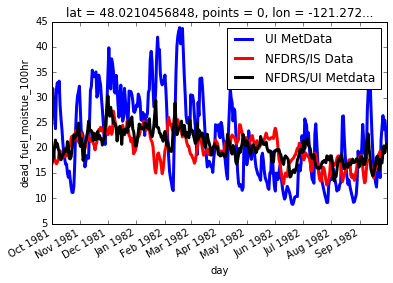

In [26]:
import datetime as dt
import matplotlib.pyplot as plt
base = dt.datetime(1950, 1, 1)
end_date = dt.datetime(2006, 1, 1)
tp_start = dt.datetime(1981,10,1)
tp_end = dt.datetime(1982,10,1)
arr_dates = [base + dt.timedelta(days=i) for i in range(0, (end_date-base).days)]
arr_datess = np.asarray(arr_dates)
date_range = [tp_start + dt.timedelta(days=i) for i in range(0, (tp_end-tp_start).days)]

ui_start = dt.datetime(1980,12,31)
ui_end = dt.datetime(1982,12,31)
arr_ui = [ui_start + dt.timedelta(days=i) for i in range(0, (ui_end-ui_start).days)]
dates_ui = np.asarray(arr_ui)

lon_ind = np.argmin(np.abs(ds.lon - lon))
lat_ind = np.argmin(np.abs(ds.lat - lat))

lw = 3.0

dfm = ds_full.isel_points(lon=[lon_ind],lat=[lat_ind])
dfm_sel = dfm.sel(day=slice('1981-10-01', '1982-9-30'))
dfm_sel['dead_fuel_moistue_100hr'].plot(label='UI MetData',linewidth=lw)

plt.plot(date_range,np.asarray(arr_mc100)[(arr_datess >= tp_start) * (arr_datess < tp_end)],color='r',
         label='NFDRS/IS Data',linewidth=lw)

plt.plot(date_range,np.asarray(arr_mc100_ui)[(dates_ui >= tp_start) * (dates_ui < tp_end)],color='k',
         label='NFDRS/UI Metdata',linewidth=lw)

plt.legend(loc='upper right')

## save plot
direc = '/raid9/gergel/agg_snowpack/'
plotname = 'dfm_comparison_one_gridcell' 
savepath = os.path.join(direc, plotname)
print ("saving figure to '%s'" % savepath)
plt.savefig(savepath)

In [25]:
nfdrs_ui = np.asarray(arr_mc100_ui)[(dates_ui >= tp_start) * (dates_ui < tp_end)]
dfm_ui = dfm_sel['dead_fuel_moistue_100hr']
nfdrs_is = np.asarray(arr_mc100)[(arr_datess >= tp_start) * (arr_datess < tp_end)]
print('the correlation between nfdrs ui and ui dfm is %.3f' %np.corrcoef(nfdrs_ui,dfm_ui)[0,1])
print('the correlation between ui nfdrs and is nfdrs is %.3f' %np.corrcoef(nfdrs_ui,nfdrs_is)[0,1])
print('the correlation between is nfdrs and ui dfm is %.3f' %np.corrcoef(nfdrs_is,dfm_ui)[0,1])


the correlation between nfdrs ui and ui dfm is 0.651
the correlation between ui nfdrs and is nfdrs is 0.612
the correlation between is nfdrs and ui dfm is 0.387


saving figure to '/raid9/gergel/agg_snowpack/dfm_gridcell'


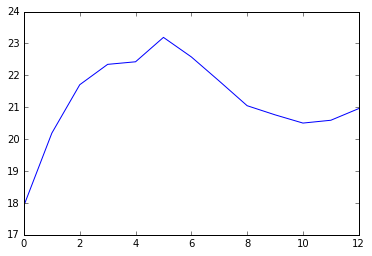

In [10]:
plt.plot(np.asarray(arr_mc100)[0:13])
#plt.plot(np.asarray(arr_mc100)[:])

## save plot
direc = '/raid9/gergel/agg_snowpack/'
plotname = 'dfm_gridcell' 
savepath = os.path.join(direc, plotname)
print ("saving figure to '%s'" % savepath)
plt.savefig(savepath)